In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/rituc/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
## load files
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [4]:
train.head()


,image_id,label
0,train_1a,rice
1,train_1b,candy
2,train_1c,jam
3,train_1d,coffee
4,train_2a,vinegar


In [5]:
print ('The train data has {} images.'.format(train.shape[0]))
print ('The test data has {} images.'.format(test.shape[0]))

The train data has 3215 images.
The test data has 1732 images.


In [6]:
# unique label count
print ('The train data has {} unique labels'.format(train['label'].nunique()))

The train data has 25 unique labels


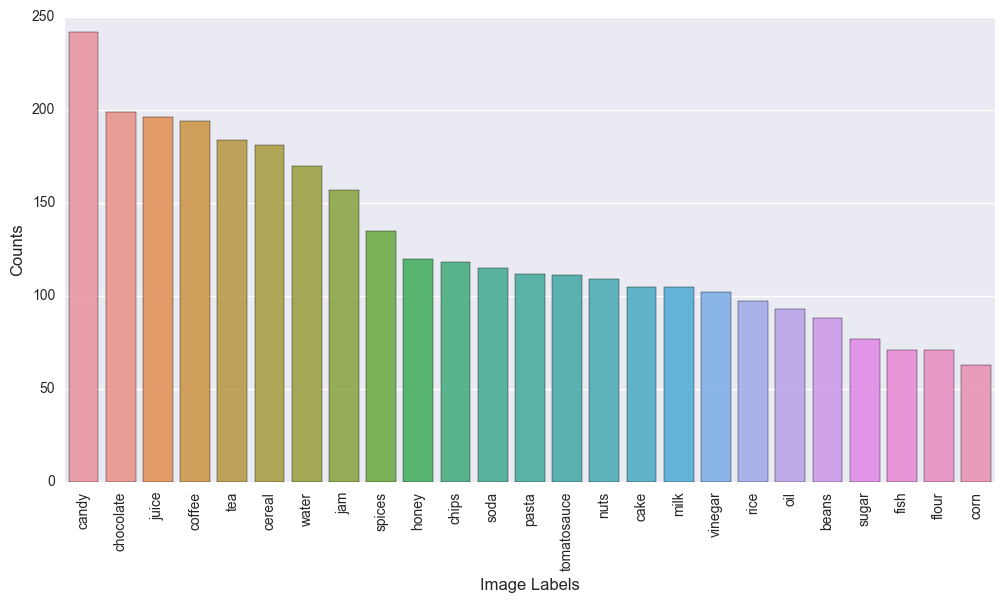

In [7]:
# lets see the distribution

label_counts = train.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [13]:
# set path to read train and test image
TRAIN_PATH = 'dataset/train_img/'
TEST_PATH = 'dataset/test_img/'

In [14]:
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64,64)) # you can resize to  (128,128) or (256,256)
    return img

In [15]:
train_data = []
test_data = []
train_labels = train['label'].values

In [16]:
for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:26<00:00, 64.19it/s]


In [17]:
# normalize the images
x_train = np.array(train_data, np.float32) / 255.0
x_test = np.array(test_data, np.float32) / 255.0

In [18]:
# target variable - encoding numeric value
label_list = train['label'].tolist()
Y_train = {k:v+1 for v,k in enumerate(set(label_list))}
y_train = [Y_train[k] for k in label_list]

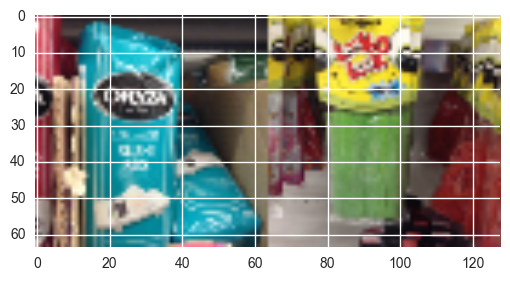

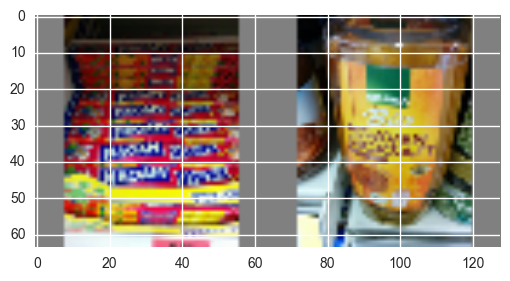

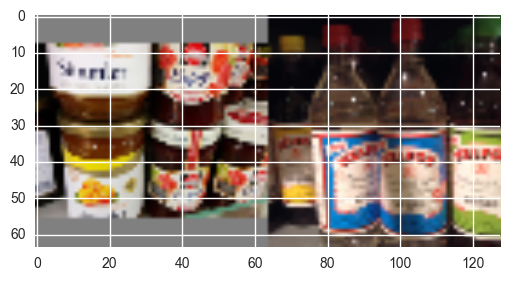

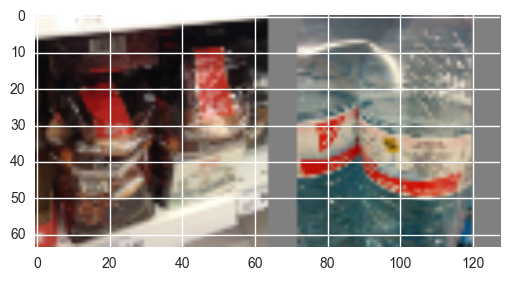

In [19]:
# check some images
def show_images(ix):
    image_train = read_image(TRAIN_PATH + train.image_id[ix] + '.png')
    image_test = read_image(TEST_PATH + test.image_id[ix] + '.png')
    
    pair = np.concatenate((image_train, image_test), axis=1)
    
    plt.figure(figsize = (6,6))
    plt.imshow(pair)
    
# first 4 images in train and test set
for idx in range(4):
    show_images(idx)

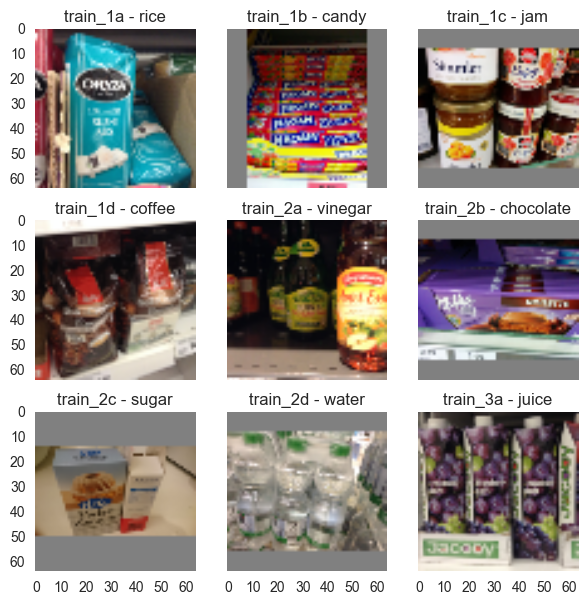

In [20]:
## just images doesn't help, lets see the images with their respective labels
plt.rc('axes', grid=False)

_, axs = plt.subplots(3,3, sharex = 'col', sharey='row', figsize = (7,7))
axs = axs.ravel()

# lets see first 8 images - you can increase i value to see more images
for i, (image_name, label) in enumerate(zip(train.image_id, train.label)):
    if i <= 8:
        img = read_image(TRAIN_PATH + image_name + '.png')
        axs[i].imshow(img)
        axs[i].set_title('{} - {}'.format(image_name, label))
    else:
        break

In [30]:
train_labels

array(['rice', 'candy', 'jam', ..., 'nuts', 'candy', 'coffee'], dtype=object)

In [44]:
train_labels

array(['rice', 'candy', 'jam', ..., 'nuts', 'candy', 'coffee'], dtype=object)

In [33]:
import tensorflow as tf

In [34]:
a = tf.truncated_normal([16,128,128,3])

In [35]:
a

<tf.Tensor 'truncated_normal:0' shape=(16, 128, 128, 3) dtype=float32>

In [36]:
sess = tf.Session()

In [37]:
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [38]:
sess.run(tf.shape(a))

array([ 16, 128, 128,   3], dtype=int32)

In [40]:
# sess.run(a)

In [42]:
b = tf.reshape(a, [16, (128*128*3)])

In [43]:
sess.run(tf.shape(b))

array([   16, 49152], dtype=int32)

In [45]:
train_labels

array(['rice', 'candy', 'jam', ..., 'nuts', 'candy', 'coffee'], dtype=object)

In [55]:
img_size = 64
num_channels = 3

In [46]:
num_classes = len(train_labels)

In [47]:
num_classes

3215

In [48]:
# validation split
validation_size = 0.2
 
# batch size
batch_size = 16

In [49]:
def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
 
def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))

In [51]:
def create_convolutional_layer(input,
                              num_input_channels,
                              conv_filter_size,
                              num_filters):
    weights = create_weights(shape=[conv_filter_size,
                                   conv_filter_size,
                                   num_input_channels,
                                   num_filters])
    bias = create_biases(num_filters)
    
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    layer += bias
    
    layer = tf.nn.max_pool(value=layer,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    
    layer = tf.nn.relu(layer)
    return layer

In [52]:
def create_flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features])
 
    return layer

In [53]:
def create_fc_layer(input,
                   num_inputs,
                   num_outputs,
                   use_relu=True):
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    layer = tf.matmul(input, weight) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [56]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
 
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [57]:
layer_conv1 = create_convolutional_layer(input=x,
                                         num_input_channels=num_channels,
                                        con_filter_size=filter_size_conv1,
                                        num_filters=num_filters_conv1)


layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)
 
layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)
          
layer_flat = create_flatten_layer(layer_conv3)
 
layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)
 
layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False)

NameError: name 'filter_size_conv1' is not defined

In [ ]:
y_pred = tf.nn.softmax(layer_fc2, name="y_pred")
y_pred_cls = tf.arg_max(y_pred, dimension=1)

In [ ]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

In [ ]:
cost = tf.reduce_mean(cross_entropy)

In [58]:
optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.0004).minimize(cost)

NameError: name 'cost' is not defined

In [ ]:
batch_size = 16
 
x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
 
feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
 
session.run(optimizer, feed_dict=feed_dict_tr)

In [ ]:
x_valid_batch, y_valid_batch, _, valid_cls_batch = data.train.next_batch(batch_size)
feed_dict_val = {x: x_valid_batch,
                      y_true: y_valid_batch}
 
val_loss = session.run(cost, feed_dict=feed_dict_val)

In [1]:
# 3. Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
 
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# 5. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
 
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
 
# 7. Define model architecture
model = Sequential()
 
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
 
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)

Using TensorFlow backend.


ValueError: Negative dimension size caused by subtracting 3 from 1 for 'Conv2D' (op: 'Conv2D') with input shapes: [?,1,28,28], [3,3,28,32].